In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime, timedelta

### Fictitious site

In [2]:
Equipment = ["Compressor-1","Compressor-2","Compressor-3",
            "Dehydrator-1","Tank-1","Tank-2","Separator-1","Separator-2","Separator-3",
            "Wellhead"]

### Load initial emission observations

In [3]:
file_path = "Sample_site_simulated_observations_case_1.xlsx"

In [4]:
CMS = pd.read_excel(file_path, sheet_name='CMS', header=0)

In [5]:
CMS.head(2)

,id,siteId,equipmentId,startTime,endTime,rate (kg/hr)
0,CMS-89,A,Compressor-3,2024-01-01 02:16:00,2024-01-01 18:46:00,13.437431
1,CMS-88,A,Compressor-2,2024-01-01 17:12:00,2024-01-02 00:32:00,11.053783


##### description of CMS observation data
- **id**: unique ID
- **siteId**: site ID of the fictitious site.
- **equipmentId**: equipment ID of the source attributed by CMS system
- **startTime**: start time calculated by CMS system.
- **endTime**: end time calcualted by CMS system.
- **rate (kg/hr)**: quantified rate of the emission.

In [6]:
Flyover = pd.read_excel(file_path, sheet_name='Flyover', header=0)

In [7]:
Flyover.head(2)

,id,siteId,equipmentId,detectionTime,detection,surveyTime,rate (kg/hr)
0,FLY-1,A,NaN,NaT,False,2024-01-07 17:31:00,1538.3
1,FLY-2,A,Compressor-2,2024-02-22 19:40:00,True,2024-02-22 15:40:00,53.0


##### description of Flyover observation data
- **id**: unique ID
- **siteId**: site ID of the fictitious site.
- **detecetionTime**: the time when plume detected by aircraft.
- **detection**: True -> detection| Flase -> non-detects
- **surveyTime**: time when survey was conducted
- **rate (kg/hr)**: quantified rate of the emission.

In [8]:
OGI = pd.read_excel(file_path, sheet_name='OGI', header=0)

In [9]:
OGI.head(2)

,id,siteId,equipmentId,detection,surveyTime,numberOfLeaks
0,OGI-1,A,NaN,False,2024-01-01 17:31:00,0
1,OGI-2,A,NaN,True,2024-02-01 15:40:00,2


##### description of OGI observation data
- **id**: unique ID.
- **siteId**: site ID of the fictitious site.
- **detection**: True -> detection| Flase -> non-detects.
- **surveyTime**: time when OGI survey was conducted.
- **numberOfLeaks**: number of leaks found in the survey. 

In [10]:
Vent = pd.read_excel(file_path, sheet_name='Vent', header=0)

In [11]:
Vent.head(2)

,id,siteId,equipmentId,startTime,endTime,Mass (kg)
0,VFB-31,A,Compressor-3,2024-01-01 04:25:00,2024-01-01 04:35:00,182.796264
1,VFB-30,A,Tank-1,2024-01-01 13:34:00,2024-01-01 13:40:00,231.258690


##### description of OGI observation data
- **id**: unique ID.
- **siteId**: site ID of the fictitious site.
- **equipmentId**: equipment that assiciated with the venting event. 
- **startTime**: venting start time.
- **endTime**: venting end time.
- **Mass (kg)**: Mass vented. 

### Load emission observations and convert to emission events 
##### each emission observation initiates as one event 

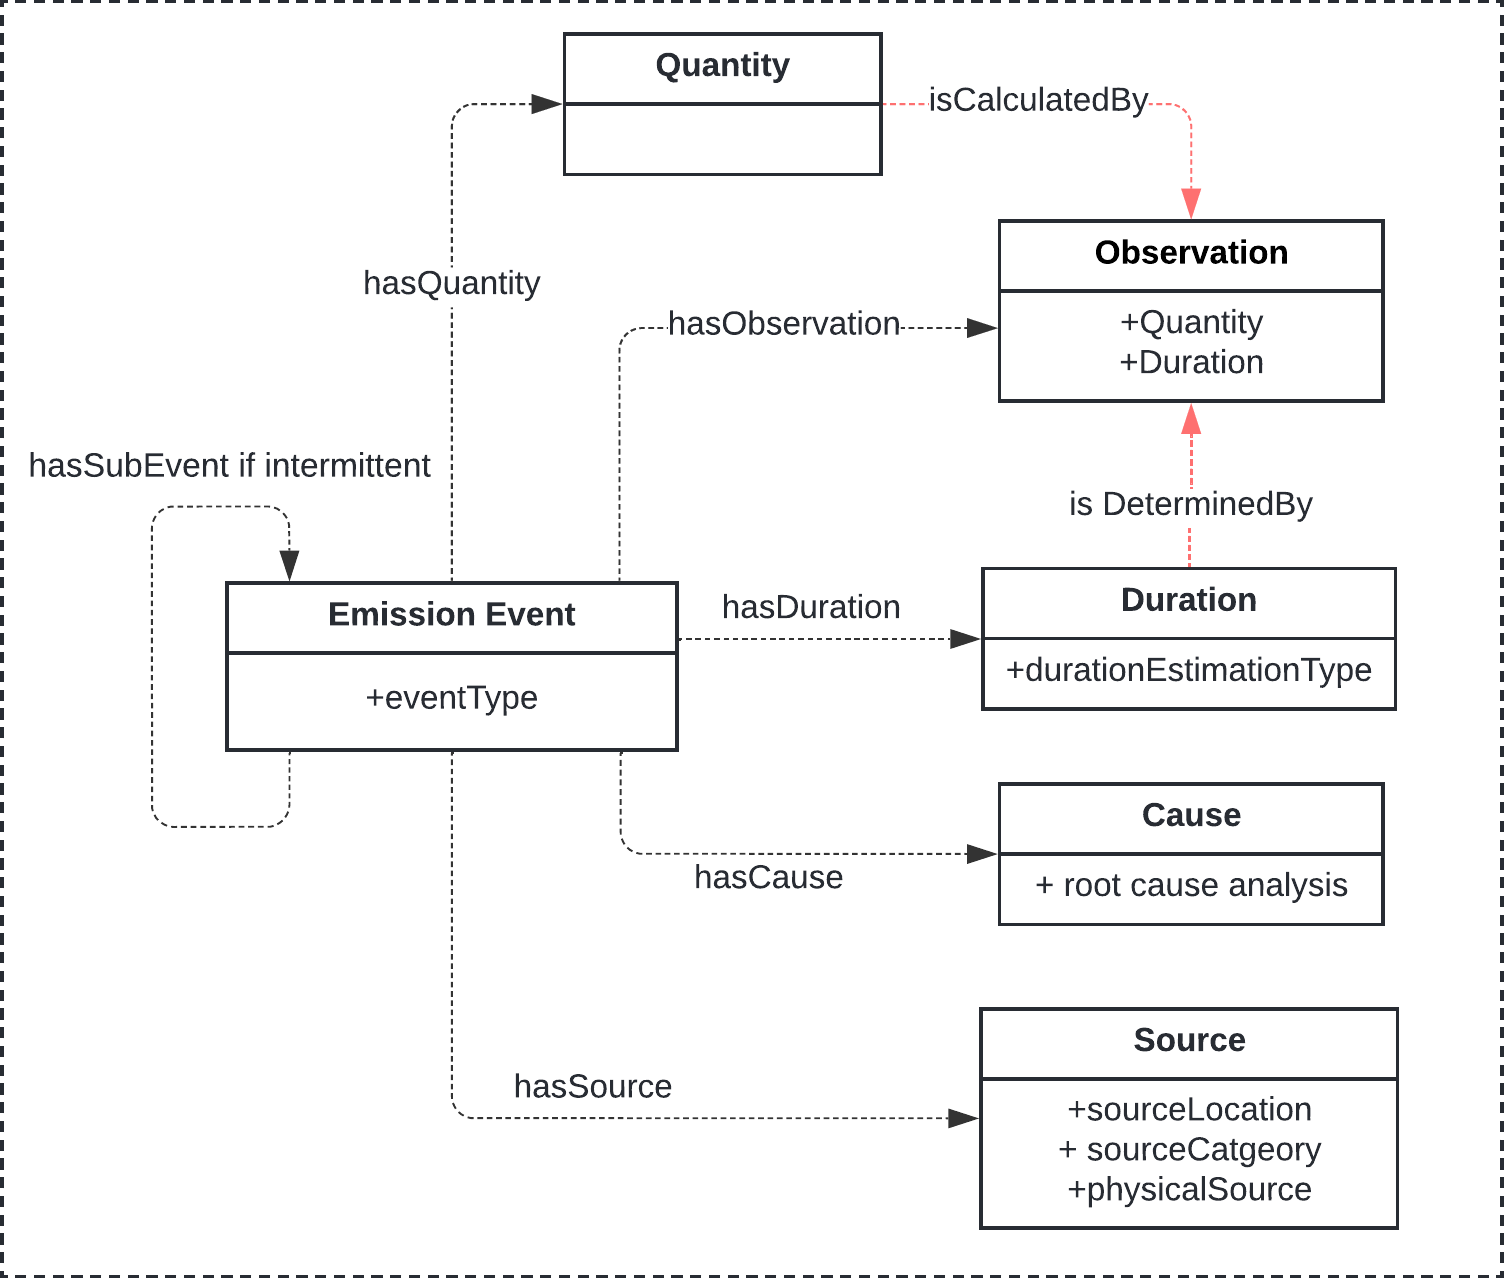

In [12]:
Image(filename='Emission Event UML - Paper UML Model.png') 

In [13]:
vent_events = [] 
for _,row in Vent.iterrows(): 
    eventType = "RE"
    startTime = row.startTime
    endTime = row.endTime
    duration = ((endTime - startTime).total_seconds())/3600
    mass = row["Mass (kg)"]
    rate = mass/duration
    vent_events.append({
        "eventType":eventType,
        "detectionTime":startTime,
        "startTime": startTime,
        "endTime": endTime,
        "duration": {"value":duration,"unit":"hr"}, 
        "oid":row.id,
        "observations":[{
            "id":row.id,
            "startTime": startTime,
            "endTime": endTime,
            "obs_mass_volume":mass,
            "obs_duration":duration,
            "obs_rate":rate,
            "obs_rate_unit": "kg/hr"
        }],
        "source": row.equipmentId,
        "quantity":{"value":mass,"unit":"kg"},
        "rate":{"value":rate,"unit":"kg/hr"},
    })

In [14]:
cms_events = [] 
for idx,row in CMS.iterrows():
    eventType = "PRE"
    startTime = row.startTime
    endTime = row.endTime
    duration = ((endTime - startTime).total_seconds())/3600
    rate = row["rate (kg/hr)"] 
    cmsId = row.id
    massVolume = rate * duration 
    cms_events.append({
        "eventType":eventType, 
        "duration": {"value":duration,"unit":"hr"}, 
        "detectionTime":startTime,
        "startTime": startTime,
        "endTime": endTime,
        "oid":row.id,
        "observations":[{
            "id":cmsId,
            "startTime": startTime,
            "endTime": endTime,
            "obs_mass_volume":massVolume,
            "obs_duration":duration,
            "obs_rate":rate,
            "obs_rate_unit": "kg/hr"
        }],
        "source": row.equipmentId,
        "quantity":{"value":massVolume,"unit":"kg"},
        "rate":{"value":rate,"unit":"kg/hr"},
    })

In [15]:
cms_events[0]

{'eventType': 'PRE',
 'duration': {'value': 16.5, 'unit': 'hr'},
 'detectionTime': Timestamp('2024-01-01 02:16:00'),
 'startTime': Timestamp('2024-01-01 02:16:00'),
 'endTime': Timestamp('2024-01-01 18:46:00'),
 'oid': 'CMS-89',
 'observations': [{'id': 'CMS-89',
   'startTime': Timestamp('2024-01-01 02:16:00'),
   'endTime': Timestamp('2024-01-01 18:46:00'),
   'obs_mass_volume': 221.71760523,
   'obs_duration': 16.5,
   'obs_rate': 13.43743062,
   'obs_rate_unit': 'kg/hr'}],
 'source': 'Compressor-3',
 'quantity': {'value': 221.71760523, 'unit': 'kg'},
 'rate': {'value': 13.43743062, 'unit': 'kg/hr'}}

In [16]:
instantaneous_measurements = pd.concat([Flyover,OGI])

In [17]:
instantaneous_measurements = instantaneous_measurements.sort_values(by=["surveyTime"])

In [18]:
instantaneous_measurements

,id,siteId,equipmentId,detectionTime,detection,surveyTime,rate (kg/hr),numberOfLeaks
0,OGI-1,A,NaN,NaT,False,2024-01-01 17:31:00,NaN,0.0
0,FLY-1,A,NaN,NaT,False,2024-01-07 17:31:00,1538.3,NaN
1,OGI-2,A,NaN,NaT,True,2024-02-01 15:40:00,NaN,2.0
1,FLY-2,A,Compressor-2,2024-02-22 19:40:00,True,2024-02-22 15:40:00,53.0,NaN
2,OGI-3,A,NaN,NaT,True,2024-03-01 16:40:00,NaN,4.0
2,FLY-3,A,Compressor-3,2024-03-22 19:40:00,True,2024-03-22 16:40:00,64.0,NaN
3,OGI-4,A,NaN,NaT,False,2024-04-01 16:14:00,NaN,0.0
3,FLY-4,A,NaN,2024-04-05 19:14:00,True,2024-04-05 16:14:00,38.5,NaN


In [19]:
ins_events = [] 
# rule based method to determine the start and end times 
# if there is a flyover non-detect before the detection, we use the halfway rule
# start time is determned as the mid time between the non-detect time and detection time 
# otherwise default to event started 180 days ago 
# if there is a non-detect after the detection, 
# the time of non-detect will be the end time of the event 
for _,row in instantaneous_measurements.iterrows(): 
    # check whether it is a detection 
    if row.detection == True and "OGI" not in row.id: 
        detection_time = row.detectionTime
        # start time 
        nd_start = instantaneous_measurements[
                    (instantaneous_measurements.surveyTime < detection_time) &
                    (instantaneous_measurements.detection == False)
                    ]
        
        if len(nd_start) > 0: 
            non_detect = nd_start.surveyTime.iloc[-1]
            # NOTES: some regulation assume the emissions started at the mid time between 
            # the non detect and detection time 
            # hour_diff = ((detection_time - non_detect).total_seconds()/3600)/2
            # start_time = non_detect + timedelta(hours = hour_diff)
            start_time = non_detect
        else: 
            start_time = detection_time - timedelta(days = 180)

        # end time 
        nd_end = instantaneous_measurements[
                    (instantaneous_measurements.surveyTime > detection_time) &
                    (instantaneous_measurements.detection == False)
                    ]

        if len(nd_end) > 0: 
            end_time = nd_end.surveyTime.iloc[0]
        else:
            # since we only reconcile from Jan.2024 to Apr.2024
            # the end time is truncated to end of Apirl 
            end_time = datetime(2024,4,30,23,59) 
        duration = (end_time - start_time).total_seconds()/3600
        rate = row["rate (kg/hr)"]
        mass_volume = rate * duration
        source = row.equipmentId if row.equipmentId in Equipment else "A"
        ins_events.append({
                "eventType":"PRE", 
                "duration": {"value":duration,"unit":"hr"},
                "detectionTime": detection_time,
                "startTime": start_time,
                "endTime": end_time,
                "oid":row.id,
                "observations":[{
                    "id":row.id,
                    "startTime": start_time,
                    "endTime": end_time,
                    "obs_mass_volume":mass_volume,
                    "obs_duration":duration,
                    "obs_rate":rate,
                    "obs_rate_unit": "kg/hr"
                }],
                "source": source,
                "quantity":{"value":massVolume,"unit":"kg"},
                "rate":{"value":rate,"unit":"kg/hr"},
            })

### Create initial events 

In [20]:
events = pd.DataFrame(ins_events+vent_events+cms_events)

In [21]:
events.head(2)

,eventType,duration,detectionTime,startTime,endTime,oid,observations,source,quantity,rate
0,PRE,"{'value': 2038.7166666666667, 'unit': 'hr'}",2024-02-22 19:40:00,2024-01-07 17:31:00,2024-04-01 16:14:00,FLY-2,"[{'id': 'FLY-2', 'startTime': 2024-01-07 17:31...",Compressor-2,"{'value': 160.76300239433334, 'unit': 'kg'}","{'value': 53.0, 'unit': 'kg/hr'}"
1,PRE,"{'value': 2038.7166666666667, 'unit': 'hr'}",2024-03-22 19:40:00,2024-01-07 17:31:00,2024-04-01 16:14:00,FLY-3,"[{'id': 'FLY-3', 'startTime': 2024-01-07 17:31...",Compressor-3,"{'value': 160.76300239433334, 'unit': 'kg'}","{'value': 64.0, 'unit': 'kg/hr'}"


In [22]:
#show attributes of emission event 
events.columns

Index(['eventType', 'duration', 'detectionTime', 'startTime', 'endTime', 'oid',
       'observations', 'source', 'quantity', 'rate'],
      dtype='object')

##### description of emission event
- **eventType**: event type of the emission event: RE and PRE.
- **duration**: duration of the event.
- **observation**: observations included in the event
- **startTime**: start time of the event.
- **endTime**: end time of the event.
- **source**: equipment/site
- **rate**: the quantified rate of emission event.
- **quantity**: total emissions emitted from the event. 

eventType
PRE    92
RE     49
Name: count, dtype: int64


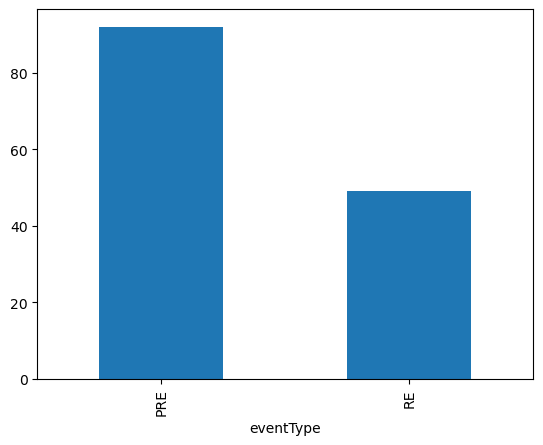

In [23]:
event_counts = events['eventType'].value_counts()
print(event_counts)
event_counts.plot(kind='bar')
plt.show()

### Merge events based on spatio-temporal correlations  
- Spatial aspect can be checked by using equipmentId associated with each event since they represnets the attributed physical source of a given event.
- Temporal aspect is checked by following temporal rules: temporal intersection and temporal inclusion. 

In [24]:
# Function to check if two intervals overlap, detection_time is within the range, and equipmentId is the same
def is_overlapping(start1, end1, detection_time1, start2, end2, detection_time2, equipmentId1, equipmentId2):
    return (not (end1 <= start2 or start1 >= end2)) and ((start1 <= detection_time2 <= end1) or (start2 <= detection_time1 <= end2) )and (equipmentId1 == equipmentId2)

In [25]:
# Function to assign labels after event merge iteratively 
def assign_labels(df):
    current_label = 1
    while df['label'].isnull().any():
        # Find the index of the first unlabelled row
        idx = df.index[df['label'].isnull()].min()
        # Get the start, end, detection time, and equipmentId of this row
        start_time = df.at[idx, 'startTime']
        end_time = df.at[idx, 'endTime']
        detection_time = df.at[idx, 'detectionTime']
        equipmentId = df.at[idx, 'source']
        # Create a list of indices to process
        indices_to_process = [idx]
        
        while indices_to_process:
            current_idx = indices_to_process.pop(0)
            df.at[current_idx, 'label'] = current_label
            # Find all rows that overlap with the current row, have detection_time within range, and the same equipmentId
            overlapping_indices = df.index[(df['label'].isnull()) & 
                                           (df.apply(lambda row: is_overlapping(start_time, end_time, detection_time, 
                                                                                row['startTime'], row['endTime'], 
                                                                                row['detectionTime'], equipmentId, 
                                                                                row['source']), axis=1))].tolist()
            # Add these overlapping indices to the list of indices to process
            indices_to_process.extend(overlapping_indices)
        
        current_label += 1

In [26]:
# assign label to each event based on spatio-temporal correlation
events['label'] = pd.Series(dtype='int')
assign_labels(events)

In [27]:
# assign unique event name to each event before merge 
event_names = [] 
for _,row in events.iterrows(): 
    event_names.append(f"Event-{str(int(row.label)).zfill(2)}")  
events["event_names"] = event_names

In [28]:
events.head()

,eventType,duration,detectionTime,startTime,endTime,oid,observations,source,quantity,rate,label,event_names
0,PRE,"{'value': 2038.7166666666667, 'unit': 'hr'}",2024-02-22 19:40:00,2024-01-07 17:31:00,2024-04-01 16:14:00,FLY-2,"[{'id': 'FLY-2', 'startTime': 2024-01-07 17:31...",Compressor-2,"{'value': 160.76300239433334, 'unit': 'kg'}","{'value': 53.0, 'unit': 'kg/hr'}",1.0,Event-01
1,PRE,"{'value': 2038.7166666666667, 'unit': 'hr'}",2024-03-22 19:40:00,2024-01-07 17:31:00,2024-04-01 16:14:00,FLY-3,"[{'id': 'FLY-3', 'startTime': 2024-01-07 17:31...",Compressor-3,"{'value': 160.76300239433334, 'unit': 'kg'}","{'value': 64.0, 'unit': 'kg/hr'}",2.0,Event-02
2,PRE,"{'value': 703.75, 'unit': 'hr'}",2024-04-05 19:14:00,2024-04-01 16:14:00,2024-04-30 23:59:00,FLY-4,"[{'id': 'FLY-4', 'startTime': 2024-04-01 16:14...",A,"{'value': 160.76300239433334, 'unit': 'kg'}","{'value': 38.5, 'unit': 'kg/hr'}",3.0,Event-03
3,RE,"{'value': 0.16666666666666666, 'unit': 'hr'}",2024-01-01 04:25:00,2024-01-01 04:25:00,2024-01-01 04:35:00,VFB-31,"[{'id': 'VFB-31', 'startTime': 2024-01-01 04:2...",Compressor-3,"{'value': 182.796264, 'unit': 'kg'}","{'value': 1096.7775840000002, 'unit': 'kg/hr'}",4.0,Event-04
4,RE,"{'value': 0.1, 'unit': 'hr'}",2024-01-01 13:34:00,2024-01-01 13:34:00,2024-01-01 13:40:00,VFB-30,"[{'id': 'VFB-30', 'startTime': 2024-01-01 13:3...",Tank-1,"{'value': 231.25869, 'unit': 'kg'}","{'value': 2312.5869, 'unit': 'kg/hr'}",5.0,Event-05


In [31]:
events.to_csv("merged_observations_case_study_1.csv")

In [32]:
# merge event based on spatio-temporal correlations
# merged events will be used in the reconciliation  
merged_event = [] 
for la in events["label"].unique():
    ldf = events[events["label"] == la] 
    if len(ldf) == 1:
        eid = ldf.event_names.iloc[0]
        event_type = ldf.eventType.iloc[0]
        duration = ldf.iloc[0].get("duration").get("value")
        start_time = ldf.iloc[0].get("startTime")
        end_time = ldf.iloc[0].get("endTime")
        source = ldf.iloc[0].get("source")
        rate = ldf.iloc[0].get("rate").get("value")
        sim_dur = True if event_type == "PRE" and "FLY" in ldf.iloc[0].get("oid") else False 

    else:
        # when there are more than one observation in an event 
        # picking the most accurate observation requires analysis 
        # the source of the observation and the root cause of the 
        # event itself. For example, the best-measured vs best-calculated 
        # framework of Veritas. In this case study,
        # we assume quantification from engineering calcualtion of venting event 
        # is more accurate than flyover and mroe accurate than quantification of cms
        # venting > flyover > cms 
        eid = ldf.event_names.iloc[0]
        if "RE" in ldf.eventType.unique():
            event_type = "RE"
            vents = ldf[ldf.eventType == "RE"]
            source = vents.iloc[0].get("source")
            sim_dur = False 
            if len(vents) == 1:
                duration = vents.iloc[0].get("duration").get("value")
                start_time = vents.iloc[0].get("startTime")
                end_time = vents.iloc[0].get("endTime")
                rate = vents.iloc[0].get("rate").get("value")
            else: 
                vents_sort = vents.sort_values(by=["startTime"])
                start_time = vents_sort.iloc[0].get("startTime")
                end_time = vents_sort.iloc[-1].get("endTime")
                duration = (end_time - start_time).total_seconds()/3600

                total_volume = 0 
                for _,row in vents_sort.iterrows():
                    total_volume += row.quantity.get("value")
                rate = total_volume/duration
        else: 
            event_type = "PRE"
            source = ldf.iloc[0].get("source")
            flyover = ldf[ldf['oid'].str.contains('FLY', na=False)]
            flyover_sort = flyover.sort_values(by=["startTime"])
            flyover_count = flyover.shape[0]
            cms = ldf[ldf['oid'].str.contains('CMS', na=False)]
            cms_sort = cms.sort_values(by=["startTime"])
            cms_count = cms.shape[0]

            sim_dur = True if cms_count == 0 else False 
            
            if flyover_count == 1: 
                if cms_count == 0: 
                    rate = flyover.iloc[0].get("rate").get("value")
                    duration = flyover.iloc[0].get("duration").get("value")
                    start_time = flyover.iloc[0].get("startTime")
                    end_time = flyover.iloc[0].get("endTime")
                else: 
                    start_time = cms_sort.iloc[0].get("startTime")
                    end_time = cms_sort.iloc[-1].get("endTime")
                    duration = (end_time - start_time).total_seconds()/3600
            
            elif flyover_count > 1: 
                if cms_count == 0: 
                    rate = 0
                    for _,row in flyover.iterrows(): 
                        rate += row.get("rate").get("value")
    
                    rate = rate/flyover_count
                    start_time = flyover_sort.iloc[0].get("startTime")
                    end_time = flyover_sort.iloc[-1].get("endTime")
                else:
                    start_time = cms_sort.iloc[0].get("startTime")
                    end_time = cms_sort.iloc[-1].get("endTime")
                    duration = (end_time - start_time).total_seconds()/3600

            else:
                if cms_count == 1:
                    rate = cms.iloc[0].get("rate").get("value")
                    duration = cms.iloc[0].get("duration").get("value")
                    start_time = cms.iloc[0].get("startTime")
                    end_time = cms.iloc[0].get("endTime") 
                    
                else: 
                    start_time = cms_sort.iloc[0].get("startTime")
                    end_time = cms_sort.iloc[-1].get("endTime")
                    duration = (end_time - start_time).total_seconds()/3600
    
                    total_volume = 0 
                    for _,row in cms_sort.iterrows():
                        total_volume += row.quantity.get("value")
                    rate = total_volume/duration
            
    merged_event.append({
        "event_ID":eid,
        "event_type": event_type,
        "source": source,
        "start_time": start_time,
        "end_time": end_time,
        "duration": duration, 
        "rate": rate,
        "quantity": rate* duration,
        "duration_simulation": sim_dur 
    })



In [33]:
m_events = pd.DataFrame(merged_event)

In [34]:
m_events.head(5)

,event_ID,event_type,source,start_time,end_time,duration,rate,quantity,duration_simulation
0,Event-01,RE,Compressor-2,2024-01-10 07:30:00,2024-03-18 09:15:00,1633.750000,1.835673,2999.031430,False
1,Event-02,RE,Compressor-3,2024-01-08 09:35:00,2024-02-29 17:25:00,1255.833333,1.208226,1517.330272,False
2,Event-03,PRE,A,2024-04-01 16:14:00,2024-04-30 23:59:00,703.750000,38.500000,27094.375000,True
3,Event-04,RE,Compressor-3,2024-01-01 04:25:00,2024-01-01 04:35:00,0.166667,1096.777584,182.796264,False
4,Event-05,RE,Tank-1,2024-01-01 13:34:00,2024-01-01 13:40:00,0.100000,2312.586900,231.258690,False


event_type
PRE    61
RE     39
Name: count, dtype: int64


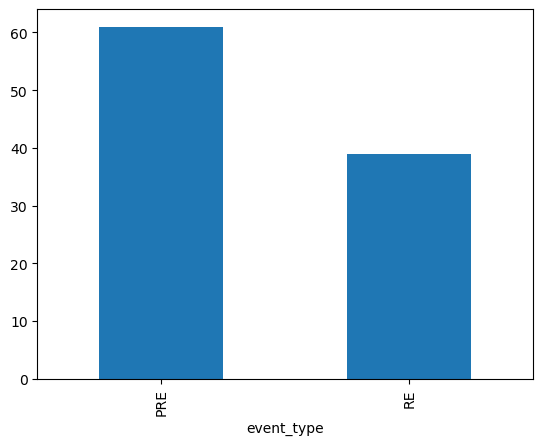

In [35]:
event_counts = m_events['event_type'].value_counts()
print(event_counts)
event_counts.plot(kind='bar')
plt.show()

In [37]:
m_events.to_csv("merged_events_case_study_1.csv",sep=',', index=False)

In [38]:
m_events.head(3)

,event_ID,event_type,source,start_time,end_time,duration,rate,quantity,duration_simulation
0,Event-01,RE,Compressor-2,2024-01-10 07:30:00,2024-03-18 09:15:00,1633.750000,1.835673,2999.031430,False
1,Event-02,RE,Compressor-3,2024-01-08 09:35:00,2024-02-29 17:25:00,1255.833333,1.208226,1517.330272,False
2,Event-03,PRE,A,2024-04-01 16:14:00,2024-04-30 23:59:00,703.750000,38.500000,27094.375000,True
